# SVR
So far the best model compared to my strategy of investment is the SVR. \
It has the best ROI even when there are difficult situation to predict. \
Also it's easy to tune and fast to compute, now let's focus on a particular stock and try to maximize the ROI over the last year.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from ForecastSimulator2 import Forecastsimulator, forecast_split
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
from dateutil.relativedelta import relativedelta
from sklearn.ensemble import BaggingRegressor

from sklearn.preprocessing import StandardScaler
from pandas_datareader import data as web

plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.grid'] = True

In [74]:
today = date.today()
start_date = today - relativedelta(years=7)

print(start_date)
data = pd.DataFrame(web.DataReader('MERC', 'stooq', start_date))
data.info()

2016-03-19
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1761 entries, 2023-03-17 to 2016-03-21
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1761 non-null   float64
 1   High    1761 non-null   float64
 2   Low     1761 non-null   float64
 3   Close   1761 non-null   float64
 4   Volume  1761 non-null   float64
dtypes: float64(5)
memory usage: 82.5 KB


In [75]:
close = data[['Close']]
close = close.sort_index(ascending = True)
close

,Close
Date,
2016-03-21,6.94516
2016-03-22,6.75805
2016-03-23,6.52559
2016-03-24,6.78591
2016-03-28,6.87255
...,...
2023-03-13,10.13000
2023-03-14,10.15000
2023-03-15,9.84000


<Axes: xlabel='Date'>

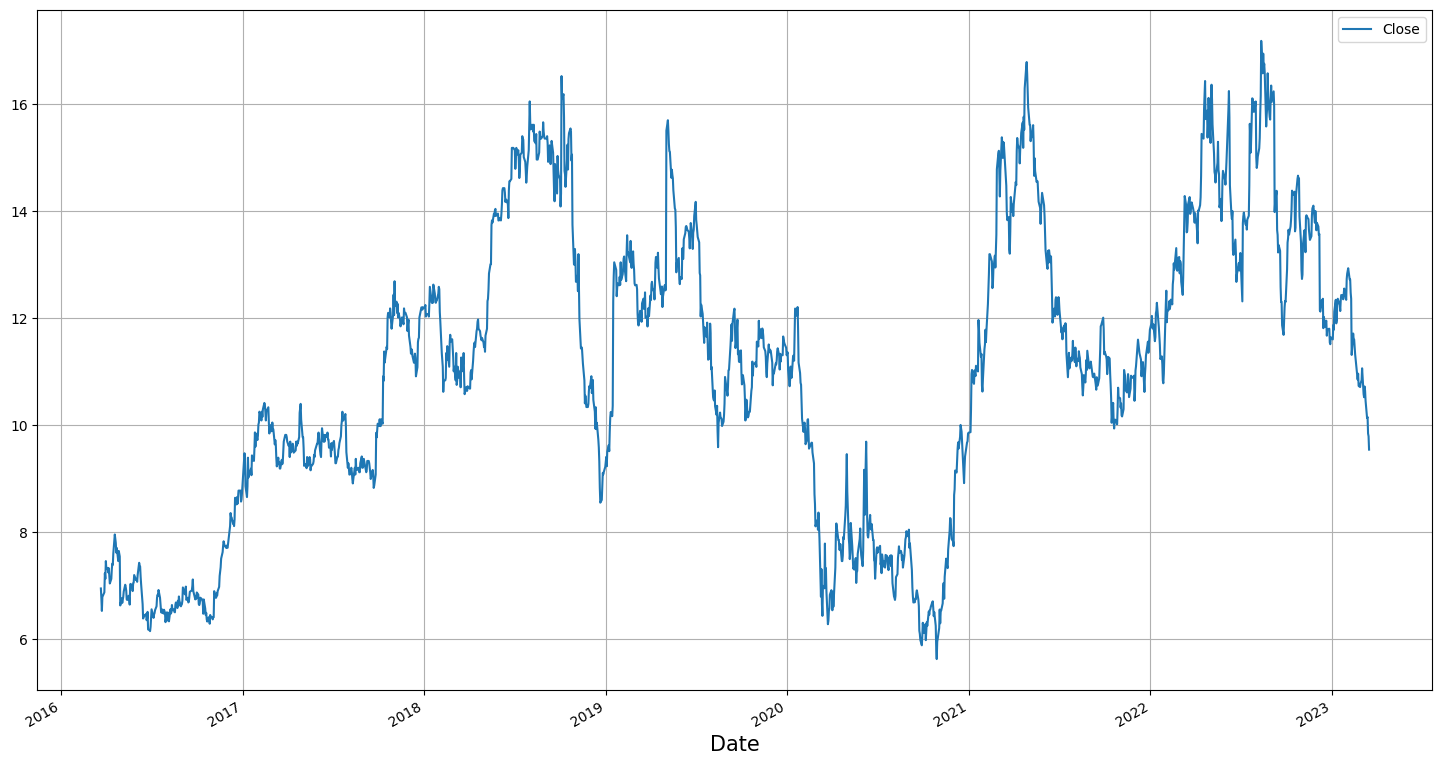

In [76]:
close.plot()

c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239


c:\Users\ggiam\anaconda3\envs\stock_forecast_2\Lib\site-packages\sklearn\ensemble\_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


240
241
242
243
244
245
246
247
248
249


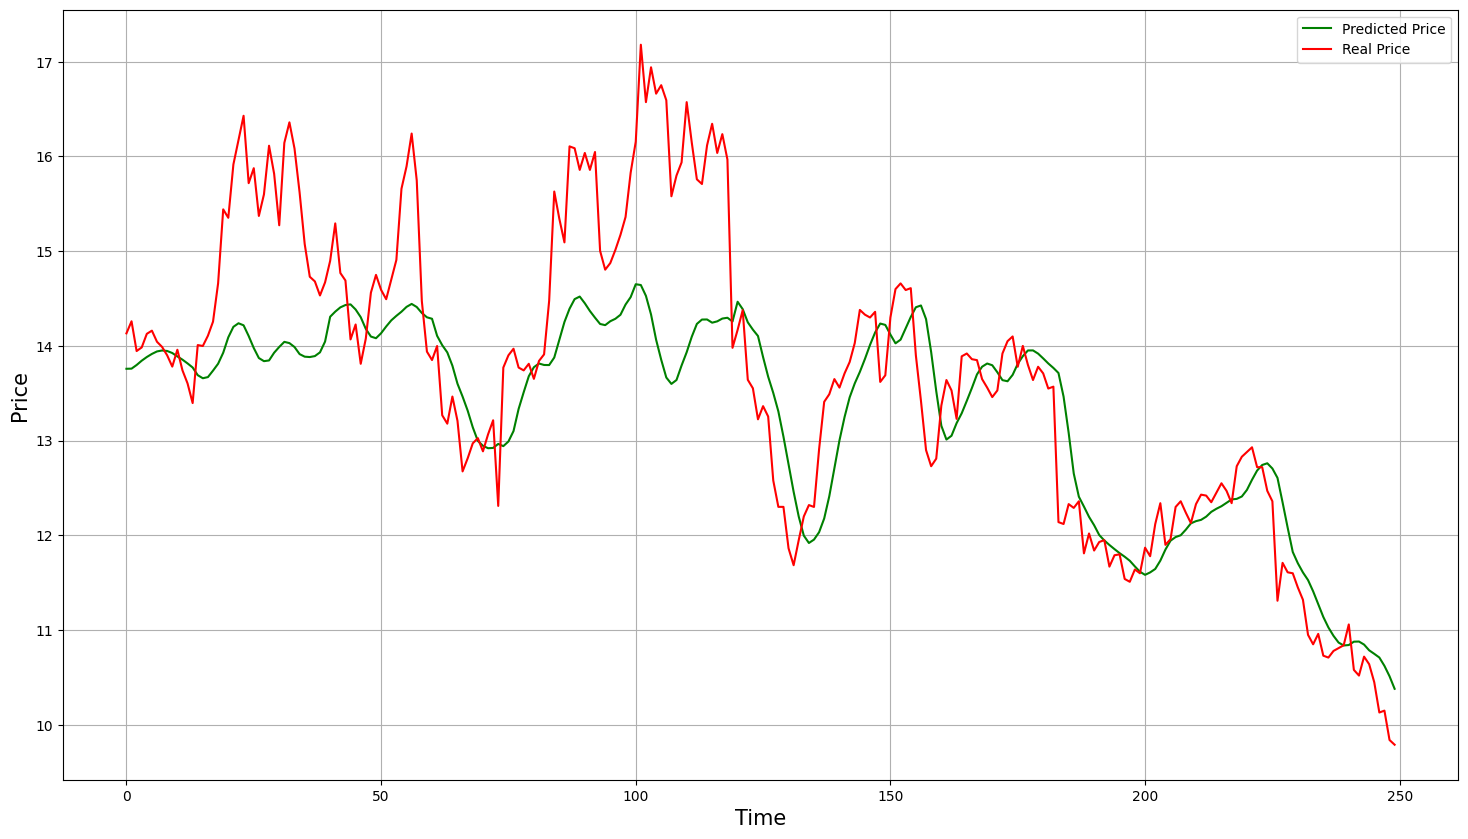

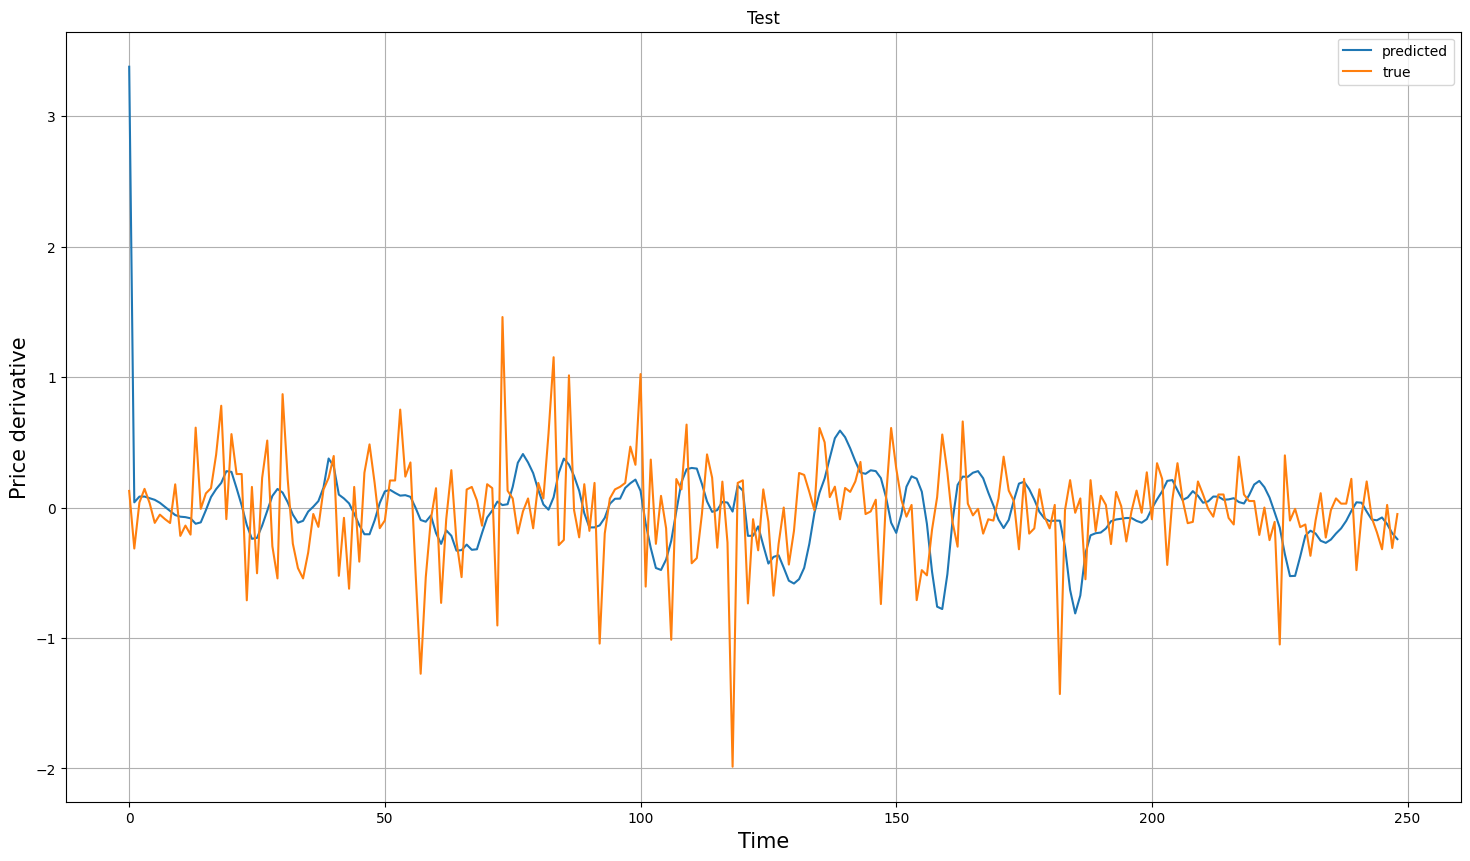

0.5564516129032258


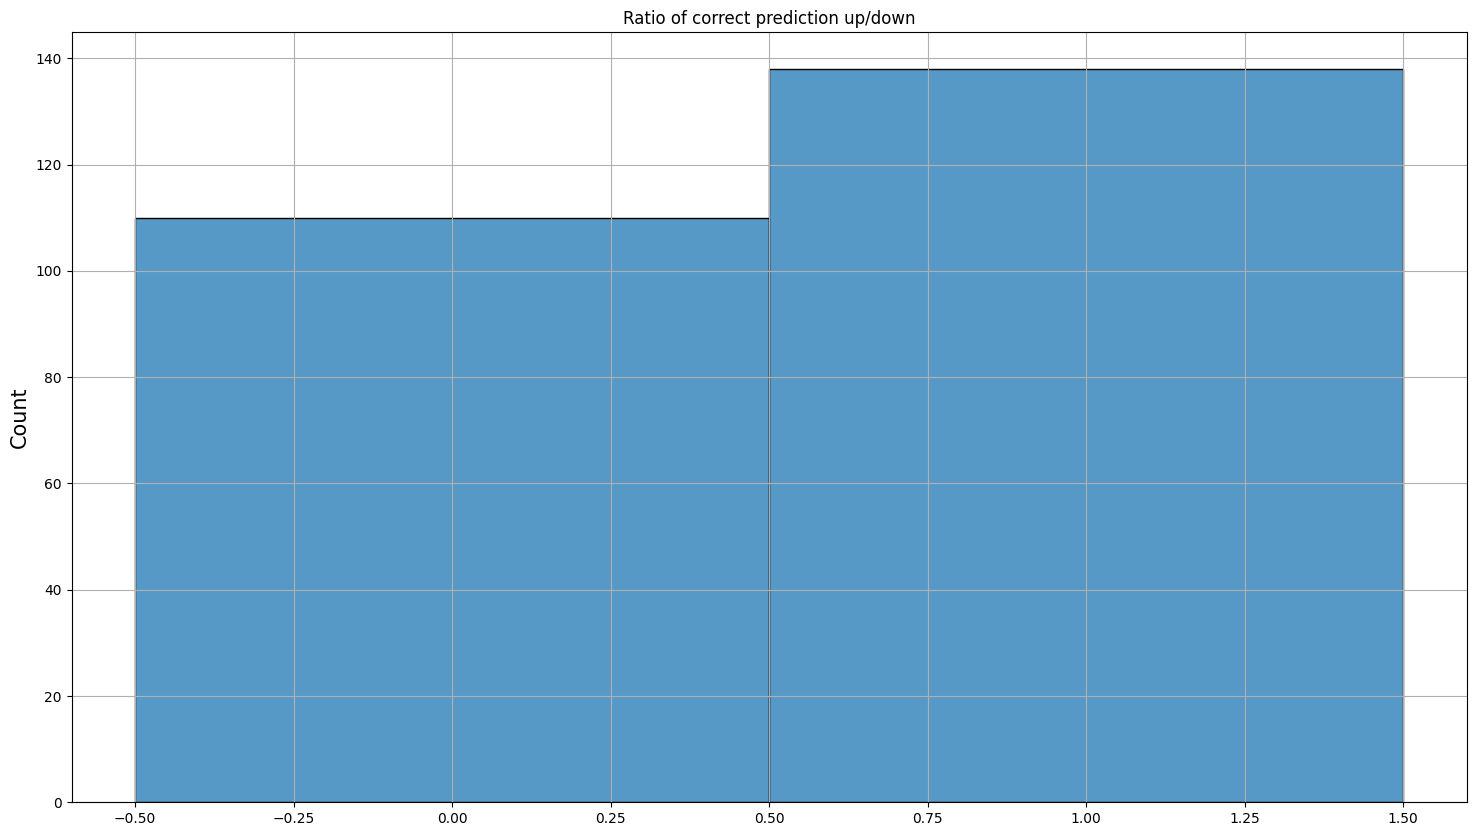

0.5660623541775895 2.687310682360374


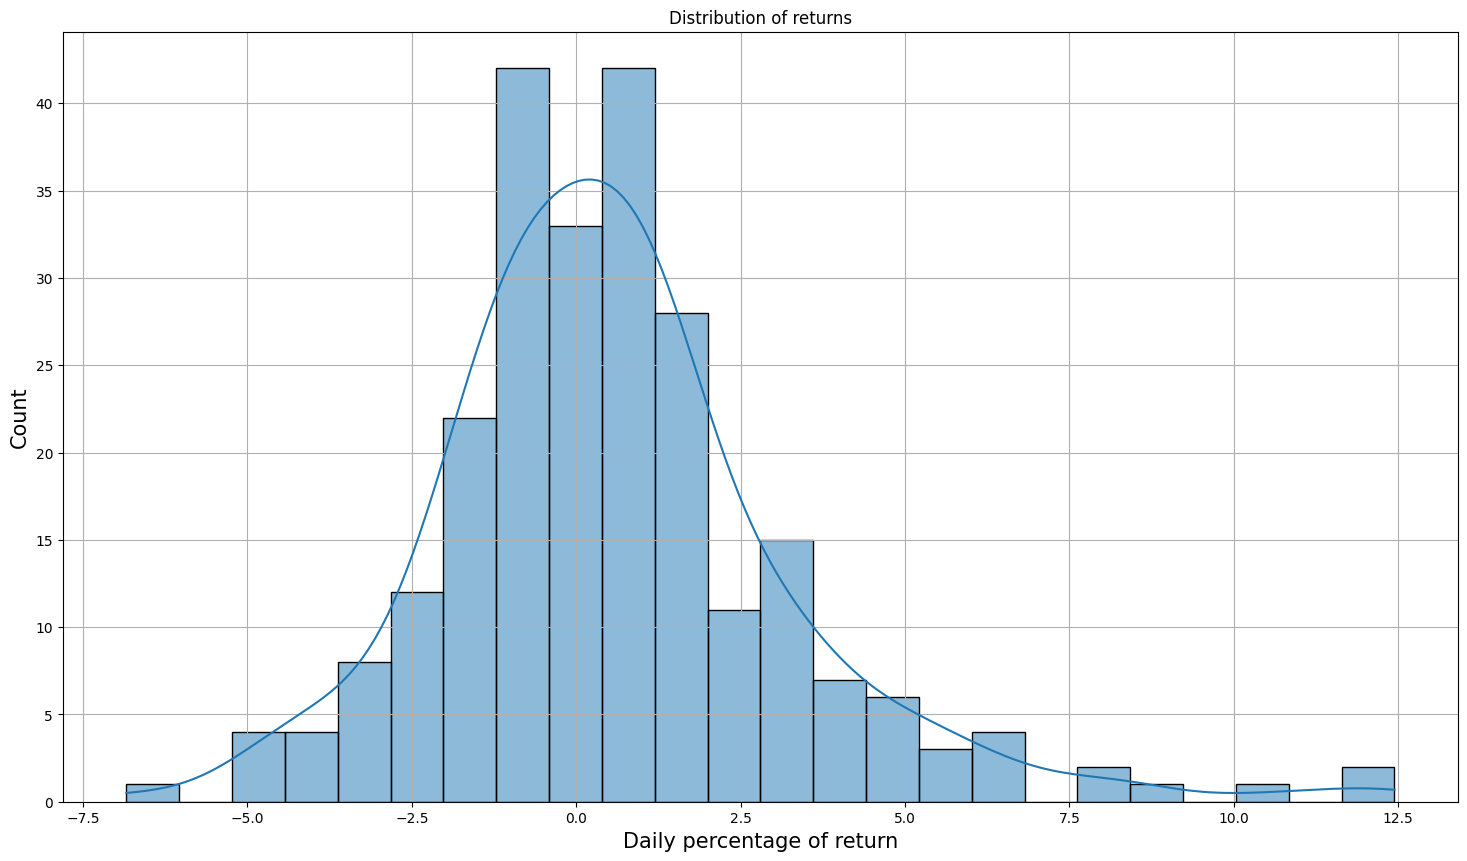

701.917319180211


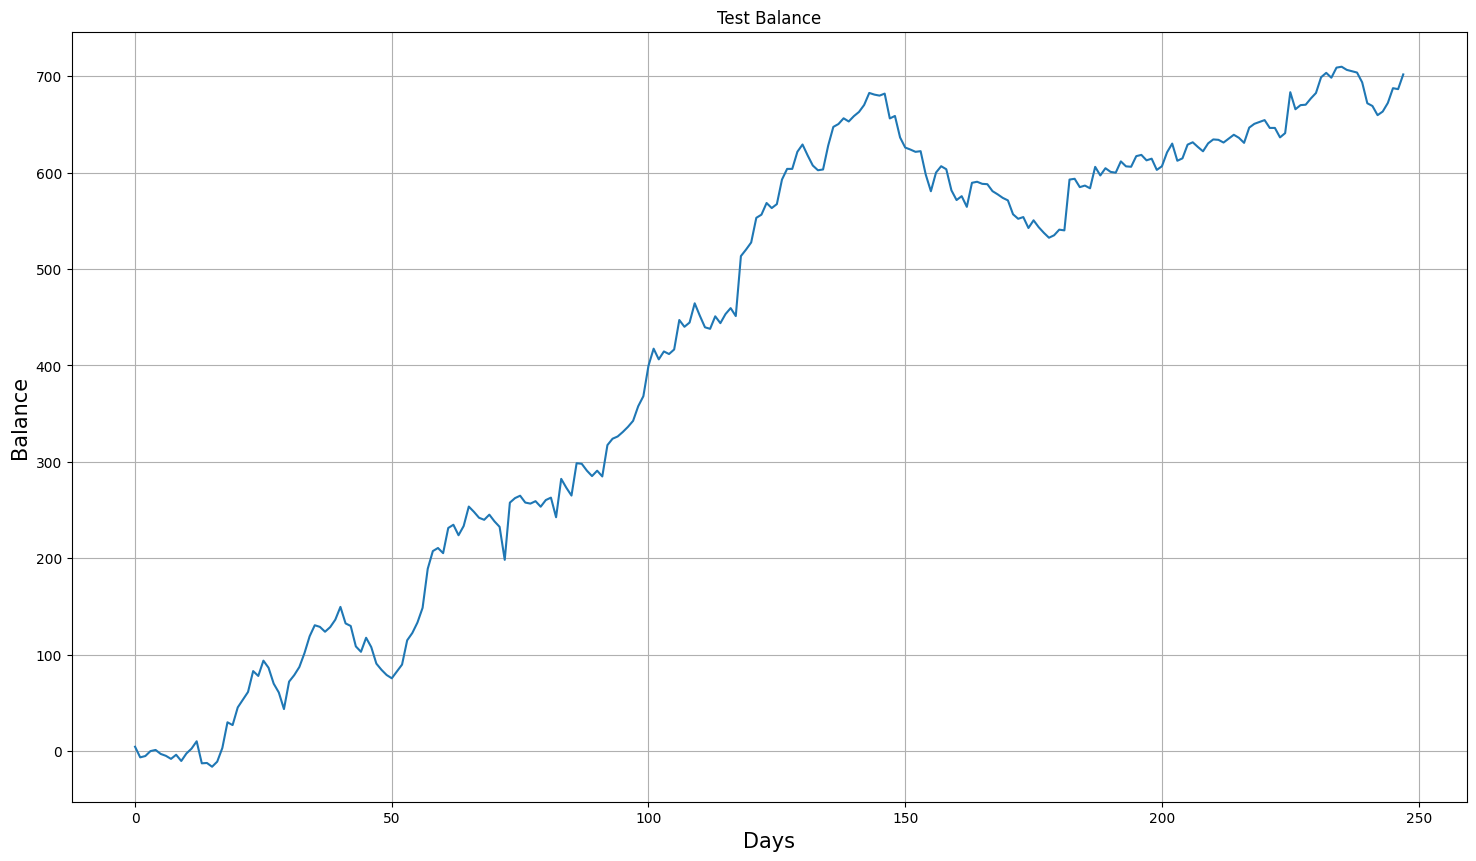

In [80]:
dtp=1
ws=5

X_train, X_test, y_train, y_test, y_true = forecast_split(close, window_size=ws, dtp=dtp, test_days=250)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

fs2 = Forecastsimulator(SVR())
pred = fs2.retrain(BaggingRegressor(SVR(C=0.01), 50), X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled, retrain_period=20)
prediction = scaler_y.inverse_transform(pred)

fs2.plot_prediction(prediction, y_true)
fs2.simulate(prediction, y_true)